In [96]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from skimage.transform import radon, iradon, resize
import cv2

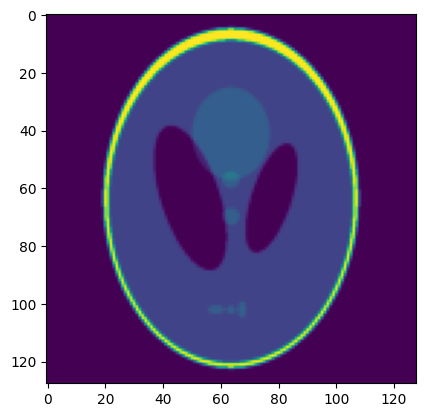

In [97]:
phantom = shepp_logan_phantom()
phantom = resize(phantom, (128, 128), mode='reflect', anti_aliasing=True)
plt.imshow(phantom)

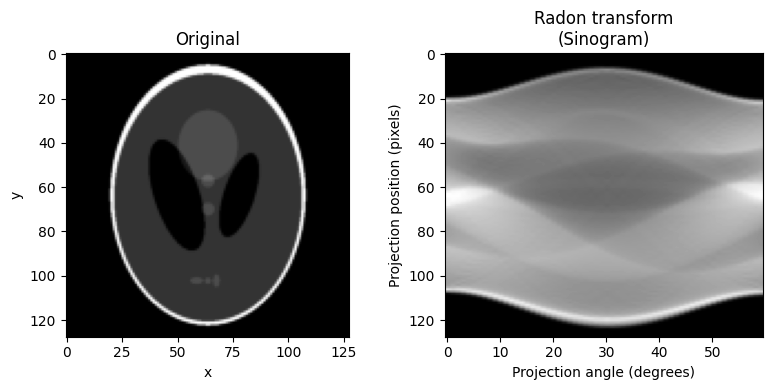

In [98]:
# Define the angles for the Radon transform
# For theta = 0, 3, 6, ..., 177
theta_vals = np.arange(0, 180, 3)

# Compute the Radon transform
sinogram = radon(phantom, theta=theta_vals, circle=True)
# Display the original image and its sinogram
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(phantom, cmap=plt.cm.gray)
ax[0].set_title("Original")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].imshow(sinogram, cmap=plt.cm.gray, aspect='auto')
ax[1].set_title("Radon transform\n(Sinogram)")
ax[1].set_xlabel("Projection angle (degrees)")
ax[1].set_ylabel("Projection position (pixels)")

fig.tight_layout()
plt.show()

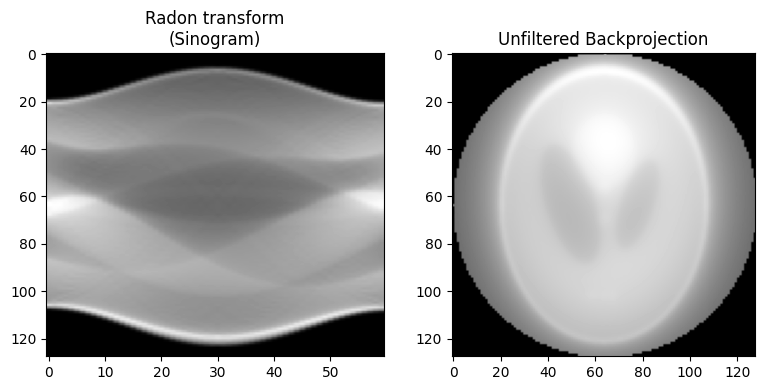

In [99]:
backproj_unfiltered = iradon(sinogram, theta=theta_vals, filter_name=None, circle=True)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(sinogram, cmap=plt.cm.gray, aspect='auto')
axes[0].set_title("Radon transform\n(Sinogram)")

axes[1].imshow(backproj_unfiltered, cmap=plt.cm.gray)
axes[1].set_title("Unfiltered Backprojection")


fig.tight_layout()
plt.show()

In [100]:
def myFilter(sinogram, filter_type='ramlak', L=None):
    n = sinogram.shape[0]
    # Compute FFT frequencies along the detector axis (assume pixel spacing = 1)
    freq = np.fft.fftfreq(n, d=1.0)   # in cycles per pixel
    w = np.abs(freq)
    if L is None:
        L = np.max(w)  # wmax

    # Define the filter function (with a sharp cutoff at L)
    if filter_type.lower() == 'ramlak':
        H = w * (w <= L)
    elif filter_type.lower() == 'shepplogan':
        # Use np.sinc which is sin(pi*x)/(pi*x) by default.
        H = w * np.sinc(w/(2*L)) * (w <= L)
    elif filter_type.lower() == 'cosine':
        H = w * np.cos(np.pi * w/(2*L)) * (w <= L)
    else:
        raise ValueError("Unknown filter type.")
    
    # Reshape H for broadcasting over angles.
    H = H[:, np.newaxis]  # shape (n,1)
    
    # FFT along detector axis (axis=0) for each projection.
    sino_fft = np.fft.fft(sinogram, axis=0)
    # Multiply each column by the filter.
    sino_fft_filtered = sino_fft * H
    # Inverse FFT to obtain the filtered sinogram.
    filtered_sino = np.real(np.fft.ifft(sino_fft_filtered, axis=0))
    
    return filtered_sino

In [101]:
def filtered_backproject(sinogram, theta, filter_type, L):
    filtered_sino = myFilter(sinogram, filter_type, L)
    # Using iradon with filter=None (since filtering is already done).
    reconstruction = iradon(filtered_sino, theta=theta, filter_name=None, circle=True)
    return reconstruction

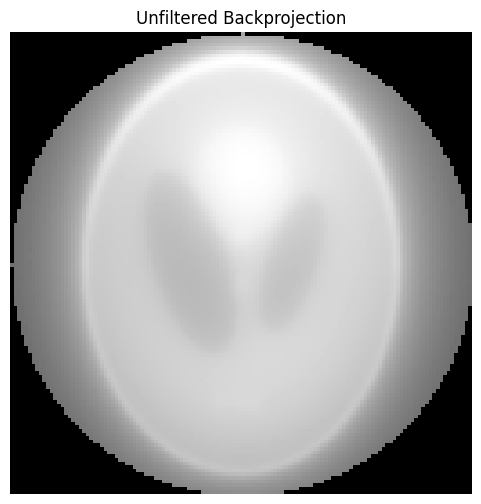

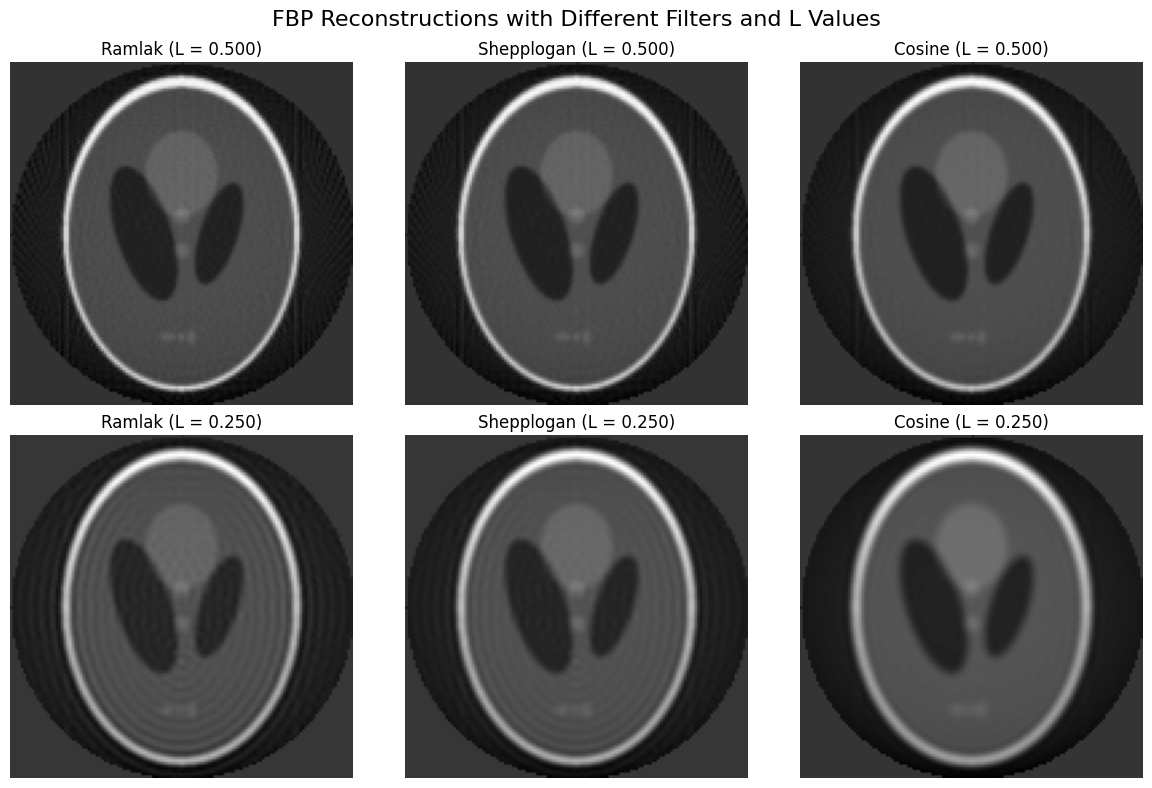

In [102]:
# Determine wmax (the highest frequency in the FFT domain for the sinogram's detector axis)
n_detectors = sinogram.shape[0]
freq = np.fft.fftfreq(n_detectors, d=1.0)
wmax = np.max(np.abs(freq))

# Define filter types and L values to test.
filter_types = ['ramlak', 'shepplogan', 'cosine']
L_values = [wmax, wmax/2]

# Plot the unfiltered backprojection.
plt.figure(figsize=(6,6))
plt.imshow(backproj_unfiltered, cmap='gray')
plt.title("Unfiltered Backprojection")
plt.axis('off')
plt.show()

# For each filter and each L value, apply filtering and backproject.
fig, axs = plt.subplots(len(L_values), len(filter_types), figsize=(12, 8))
for i, L_val in enumerate(L_values):
    for j, ftype in enumerate(filter_types):
        recon = filtered_backproject(sinogram, theta_vals, ftype, L_val)
        axs[i, j].imshow(recon, cmap='gray')
        axs[i, j].set_title(f"{ftype.title()} (L = {L_val:.3f})")
        axs[i, j].axis('off')
plt.suptitle("FBP Reconstructions with Different Filters and L Values", fontsize=16)
plt.tight_layout()
plt.show()

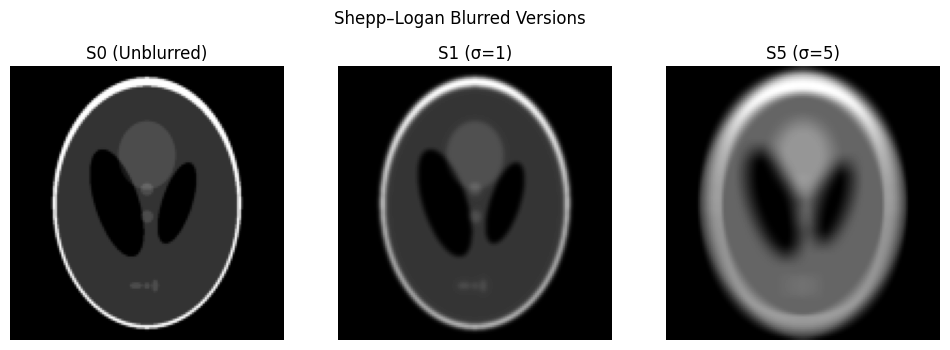

In [103]:
# Create blurred versions of the phantom.
S0 = phantom.copy()  # original (unblurred)
S1 = cv2.GaussianBlur(phantom, (11, 11), sigmaX=1 , sigmaY=1)  # approximately fspecial('gaussian', 11, 1)
S5 = cv2.GaussianBlur(phantom, (11, 11), sigmaX=5 , sigmaY=5)  # approximately fspecial('gaussian', 51, 5)

images = {'S0 (Original)': S0, 'S1 (σ=1)': S1, 'S5 (σ=5)': S5}
recons = {}  # to store the backprojections

# Display the three versions.
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, (name, img) in zip(axs, zip(["S0 (Unblurred)", "S1 (σ=1)", "S5 (σ=5)"], [S0, S1, S5])):
    ax.imshow(img, cmap='gray')
    ax.set_title(name)
    ax.axis('off')
plt.suptitle("Shepp–Logan Blurred Versions")
plt.show()

In [104]:
def rrmse(A, B):
    return np.sqrt(np.sum((A - B)**2)) / np.sqrt(np.sum(A**2))

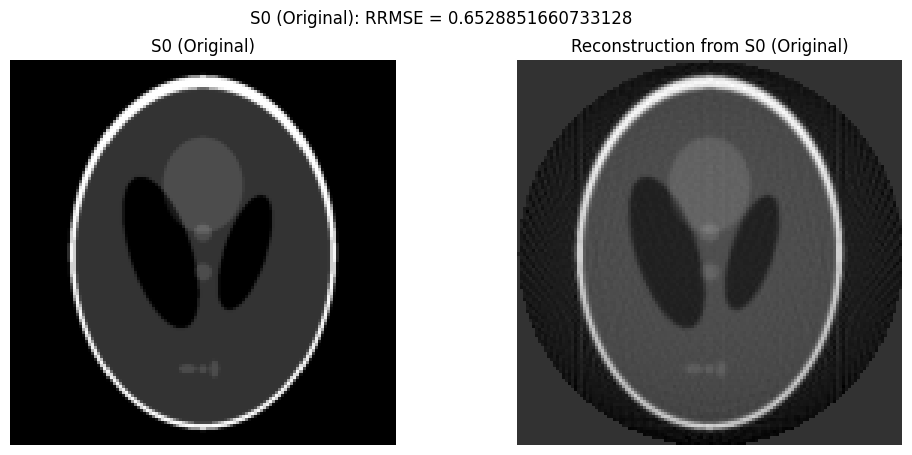

c:\Users\ARYAN KUMAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


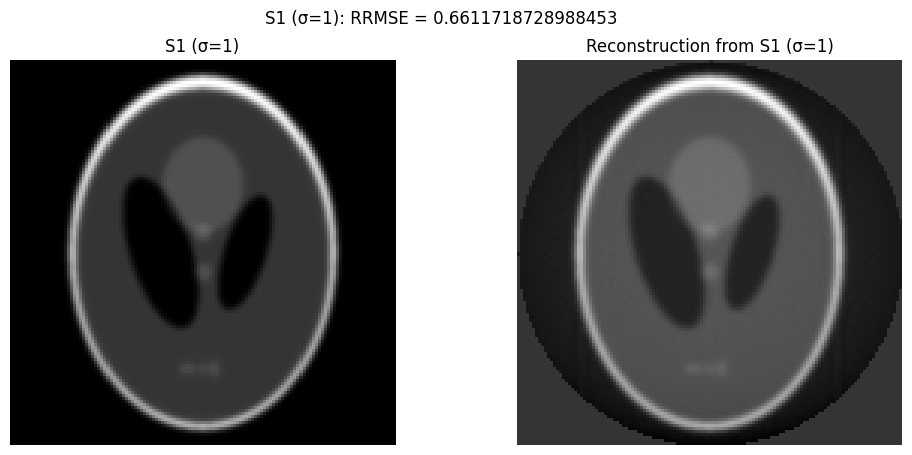

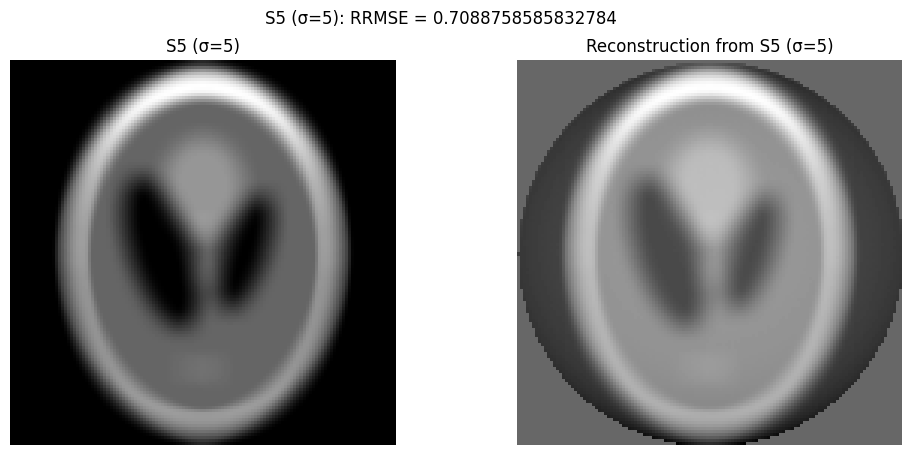

In [105]:
# For each image, compute its sinogram and reconstruct using Ram-Lak filter with L = wmax.
for key, img in images.items():
    sino_img = radon(img, theta=theta_vals, circle=True)
    # Use Ram-Lak filter with L = wmax.
    recon_img = filtered_backproject(sino_img, theta_vals, 'ramlak', wmax)
    recons[key] = recon_img
    # Compute RRMSE
    err = rrmse(img, recons[key])
    
    # Plot the sinogram and the reconstruction.
    plt.figure(figsize=(12,5))
    plt.suptitle(f"{key}: RRMSE = {err}")
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{key}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(recon_img, cmap='gray')
    plt.title(f"Reconstruction from {key}")
    plt.axis('off')
    plt.show()

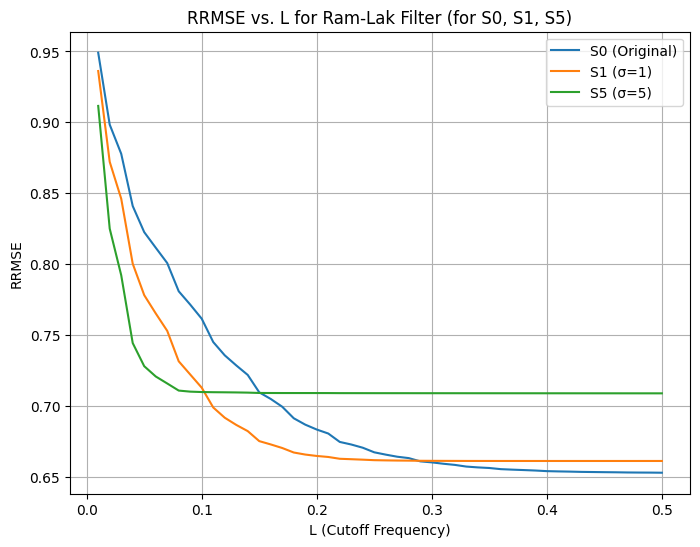

In [106]:
L_range = np.linspace(wmax/50, wmax, 50)
RRMSE_values = {key: [] for key in images.keys()}

for key, img in images.items():
    # Compute sinogram once for each image.
    sino_img = radon(img, theta=theta_vals, circle=True)
    for L_val in L_range:
        recon_img = filtered_backproject(sino_img, theta_vals, 'ramlak', L_val)
        error = rrmse(img, recon_img)
        RRMSE_values[key].append(error)

# Plot the RRMSE curves.
plt.figure(figsize=(8,6))
for key, errors in RRMSE_values.items():
    plt.plot(L_range, errors, label=key)
plt.xlabel("L (Cutoff Frequency)")
plt.ylabel("RRMSE")
plt.title("RRMSE vs. L for Ram-Lak Filter (for S0, S1, S5)")
plt.legend()
plt.grid(True)
plt.show()
